# Exercises: Learning from Demonstration

In this exercise session, two Learning from Demonstration (LfD) approaches are investigated: Probabilistic Movement Promitives (ProMP) and Trajectory parameterized Probabilistic Principal Component Analysis (TraPPCA). To do so, data are used corresponding to the insertion of solenoids, as demonstrated in the figure below.

<img src="Picture.png" width="800"> <br>
<p style="font-size: 14px;"> C. Vergara Perico, J. De Schutter, and E. Aertbeliën, "Combining imitation learning with constraint-based task specification and control", <em>IEEE Robotics and Automation Letters</em>, vol. 4, no. 2, pp. 1892 - 1899, 2019. </p>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Load data

First, the data for this exercise session are loaded and visualized.

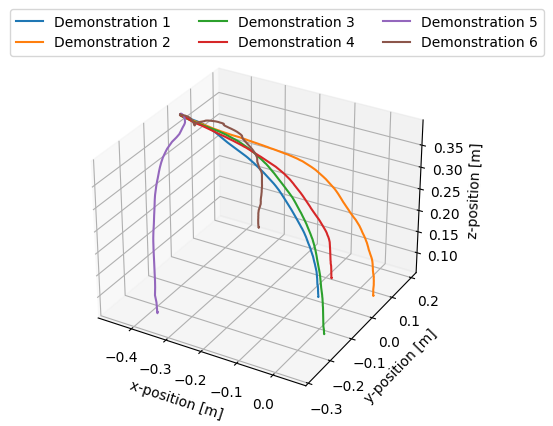

In [2]:
# Specify the path containing the data files
data_path = "Data/"

# Retrieve the file names
data_files = os.listdir(data_path)

# Retrieve the data from the data files
data = np.empty(len(data_files), dtype = "object")
for file_name, i in zip(data_files, range(0,len(data_files))):
    df_data = pd.read_csv(data_path + file_name, header=None)
    data[i] = np.array([[float(value) for value in line[0].split(" ") if len(value) > 0] for line in df_data.values[1:]])

# Visualize the data
ax = plt.axes(projection='3d')
for i in range(0,len(data)):
    ax.plot3D(data[i][:,1], data[i][:,2], data[i][:,3], label = "Demonstration " + str(i+1))
ax.set_xlabel("x-position [m]")
ax.set_ylabel("y-position [m]")
ax.set_zlabel("z-position [m]")
ax.legend(ncols = 3, bbox_to_anchor=(1.3, 1.1));

## 2. Pre-processing

To learn a motion model from a set of training demonstrations, the considered LfD approaches require the training demonstrations to be pre-processed. First, each demonstration is reparameterized in function of a progress variable between 0 (start) and 1 (end). This reparametrization aims to improve the alignment between the training demonstrations. Possible choices for the progress variable are
- Normalized time: $s_i = \frac{t_i - t_1}{T}$, with $s_i$ the progress of sample $i$, $t_i$ the time at sample $i$ and T the duration of the demonstration. This reparametrization maintains the (scaled) velocity profile along the trajectory.
- Normalized arc length using position: $s_i = \left\{
            \begin{array}{ll}
                0 & \text{if } i = 1 \\
                \frac{\sum_{k=2}^{i} ||\bold{p}_{k}-\bold{p}_{k-1}||}{\sum_{k=2}^{N} ||\bold{p}_{k}-\bold{p}_{k-1}||} & \text{else}
            \end{array}
        \right.$, with $s_i$ the progress of sample $i$, $\bold{p}_{k}$ the position of sample $k$ and $N$ the number of samples in the demonstration.

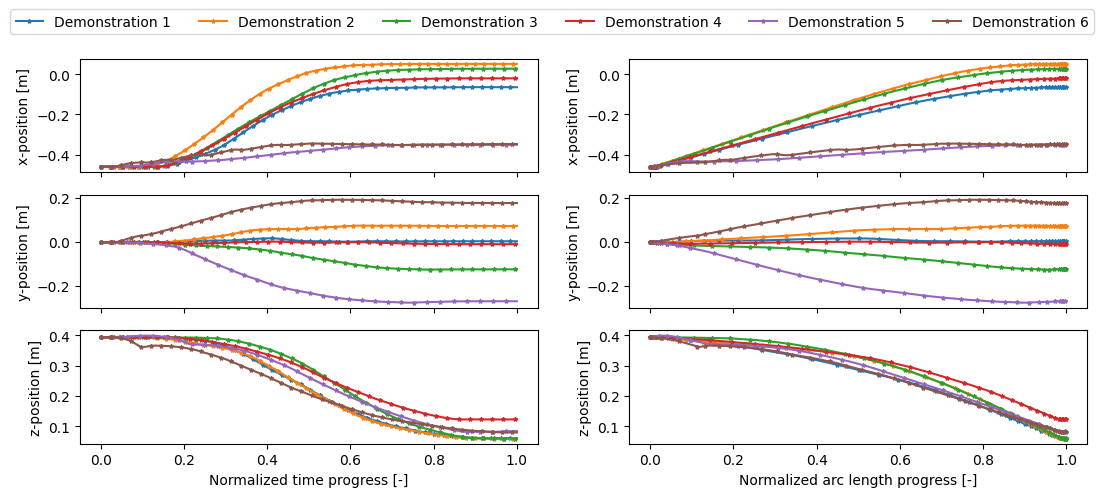

In [3]:
# Initialize the data structures
time_progress = np.empty(len(data), dtype = "object")
arc_progress = np.empty(len(data), dtype = "object")

# Iterate over the demonstrations
for i in range(0,len(data)):

    # Time steps for the current demonstration
    time = data[i][:,0]

    ####### EXERCISE #######
    # Calculate the normalized time progress (time_progress[i]) and the normalized arc length progress using position (arc_progress[i]) for demonstration i #######
    
    # Normalized time
    time_difference = time - time[0]
    time_progress[i] = time_difference/(time[-1] - time[0])

    # Normalized arc length
    arc_difference = data[i][1:, 1:] - data[i][0:-1, 1:]
    norms = np.linalg.norm(arc_difference.T, axis=0)
    sum_norms = sum(norms)
    cumsum_norms = np.cumsum(norms)
    arc_progress[i] = np.zeros(len(time))
    arc_progress[i][1:] = cumsum_norms/sum_norms

# Visualize the demonstrations in function of the progress
fig, ax = plt.subplots(np.size(data[0], 1)-1, 2, figsize = (13,5,))
for i in range(0,len(data)):
    for j in range(0,len(ax)):
        
        if j < len(ax)-1:
            ax[j,0].plot(time_progress[i], data[i][:,j+1], "-*", markersize=3, markevery = 100)
            ax[j,1].plot(arc_progress[i], data[i][:,j+1], "-*", markersize=3, markevery = 100)
            ax[j,0].xaxis.set_tick_params(labelbottom=False)
            ax[j,1].xaxis.set_tick_params(labelbottom=False)
        else:
            ax[j,0].plot(time_progress[i], data[i][:,j+1], "-*", markersize=3, markevery = 100, label = "Demonstration " + str(i+1))
            ax[j,1].plot(arc_progress[i], data[i][:,j+1], "-*", markersize=3, markevery = 100)
            ax[j,0].set_xlabel("Normalized time progress [-]")
            ax[j,1].set_xlabel("Normalized arc length progress [-]")

ax[0,0].set_ylabel("x-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[2,1].set_ylabel("z-position [m]")   
ax[2,0].legend(ncols = 6, bbox_to_anchor=(2.23, 3.9));   

Afterwards, each demonstration is resampled, such that all demonstrations have the same number of samples at consistent progress values. By doing this resampling, all demonstrations will contribute equally to the model, since more samples also means more weight.

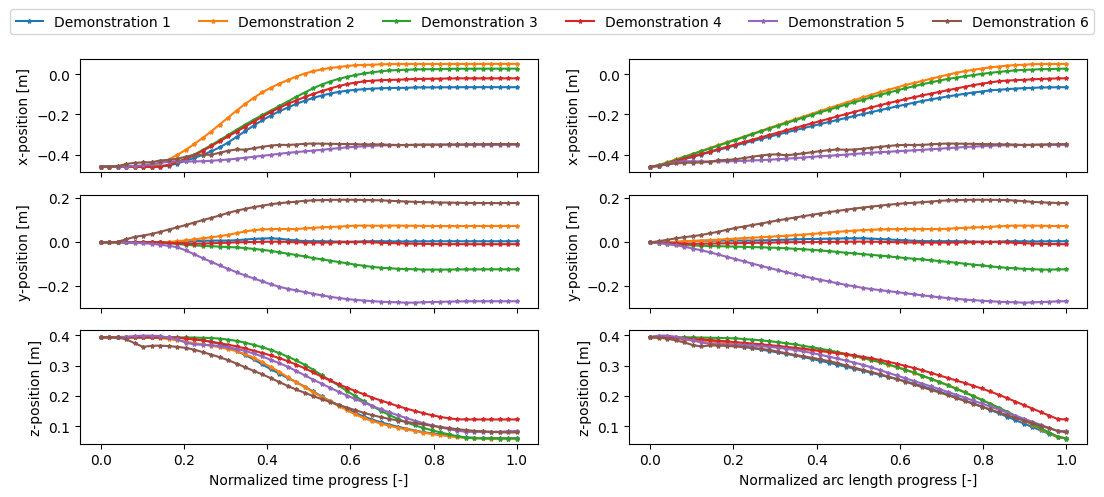

In [4]:
# Specify the desired progress values
new_progress = np.linspace(0,1,num=50)

# Initialize the data structures
resampled_data_time = np.empty([len(data), np.size(data[0], 1)-1, len(new_progress)])
resampled_data_arc = np.empty([len(data), np.size(data[0], 1)-1, len(new_progress)])

####### EXERCISE #######
# Calculate the resampled demonstrations for the normalized time progress (resampled_data_time) and the normalized arc length progress using position (resampled_data_arc) #######

# Re-sample the data
for i in range(0, len(data)):
    for j in range(0, len(resampled_data_time[0])):
        resampled_data_time[i][j] = np.interp(new_progress, time_progress[i], data[i][:,j+1])
        resampled_data_arc[i][j] = np.interp(new_progress, arc_progress[i], data[i][:,j+1])

# Visualize the resampled demonstrations in function of the progress
fig, ax = plt.subplots(len(resampled_data_time[0]), 2, figsize = (13,5,))
for i in range(0,len(data)):
    for j in range(0,len(ax)):
        
        if j < len(ax)-1:
            ax[j,0].plot(new_progress, resampled_data_time[i][j], "-*", markersize=3, markevery = int(len(new_progress)/50))
            ax[j,1].plot(new_progress, resampled_data_arc[i][j], "-*", markersize=3, markevery = int(len(new_progress)/50))
            ax[j,0].xaxis.set_tick_params(labelbottom=False)
            ax[j,1].xaxis.set_tick_params(labelbottom=False)
        else:
            ax[j,0].plot(new_progress, resampled_data_time[i][j], "-*", markersize=3, markevery = int(len(new_progress)/50), label = "Demonstration " + str(i+1))
            ax[j,1].plot(new_progress, resampled_data_arc[i][j], "-*", markersize=3, markevery = int(len(new_progress)/50))
            ax[j,0].set_xlabel("Normalized time progress [-]")
            ax[j,1].set_xlabel("Normalized arc length progress [-]")

ax[0,0].set_ylabel("x-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[2,1].set_ylabel("z-position [m]")    
ax[2,0].legend(ncols = 6, bbox_to_anchor=(2.23, 3.9));

## 3. Probabilistic Movement Primitives (ProMP)

Probabilistic Movement Primitives (ProMP) provide a probabilistic model for representing a trajectory distribution, which is based on a basis function representation. For stroke-based movements, as considered in this exercise session, Gaussian basis functions are employed and uniformly distributed along the progress axis:<br><br>
$b_j^G(s_i) = exp(- \frac{(s-c_j)^2}{2h})$,<br> <br>
with $b_j^G(s_i)$ the j-th Gaussian basis function evaluated at the current progress value $s_i$, $c_j$ the progress value at the center of the basis function and $h$ the width of the basis function. Then, these basis functions are sampled at the considered progress values and repeated for each dimension, resulting in a $N_{resampled}N_{dim} \times N_{func}N_{dim}$ block diagonal matrix $\bold{\Phi}$, with $N_{func}$ the number of basis functions along the progress axis, $N_{dim}$ the number of dimensions and $N_{resampled}$ the number of progress samples. <br><br>
To learn the ProMP model from a set of $N_{demo}$ training demonstrations, a vector of $N_{func}N_{dim}$ weights $\bold{w}_k$ is calculated for each training demonstration $k$, such that the corresponding weighted sum of the basis functions provides a proper representation of the training demonstration: <br><br>
$\bold{w}_k = (\bold{\Phi}^T\bold{\Phi} + \lambda \bold{I})^{-1} \bold{\Phi}^T \bold{y_k}$, <br><br>
where $\bold{y_k} \in \mathbb{R}^{N_{resampled}N_{dim}}$ represents training demonstration $k$ and $\lambda$ is a selected regression parameter. The probabilistic model is then obtained by calculating the mean $\bold{\mu}_w$ and covariance $\bold{\Sigma}_w$ of the weights over the $N_{demo}$ training demonstrations: <br><br>
$\bold{\mu}_w = \frac{1}{N_{demo}} \sum_{k=1}^{N_{demo}} \bold{w}_k$ <br><br>
$\bold{\Sigma}_w = \frac{1}{N_{demo}} \sum_{k=1}^{N_{demo}} (\bold{w}_k-\bold{\mu}_w)(\bold{w}_k-\bold{\mu}_w)^T$ <br><br>
This approach is implemented in function train of ProMP.py, which should not be changed for this exercise session.

In [5]:
from ProMP import ProMP

In [6]:
# Learn the ProMP model with normalized time progress
ProMP_model_time = ProMP(resampled_data_time, 10)
radial_basis_time, weights_time, weight_mean_time, weight_cov_time = ProMP_model_time.train(lmbda = 1e-12, width = 3.5*10**(-3), normalize = True)

# Learn the ProMP model with normalized arc length progress
ProMP_model_arc = ProMP(resampled_data_arc, 10)
radial_basis_arc, weights_arc, weight_mean_arc, weight_cov_arc = ProMP_model_arc.train(lmbda = 1e-12, width = 3.5*10**(-3), normalize = True)

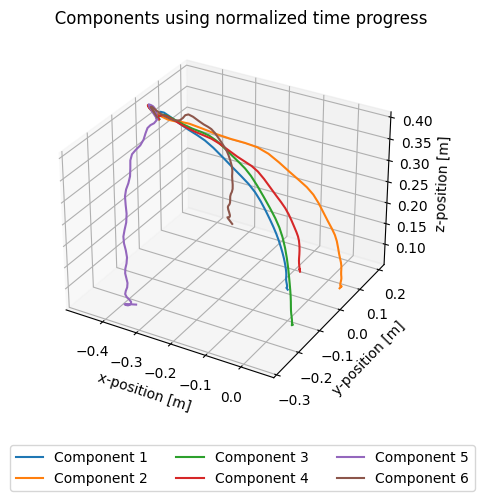

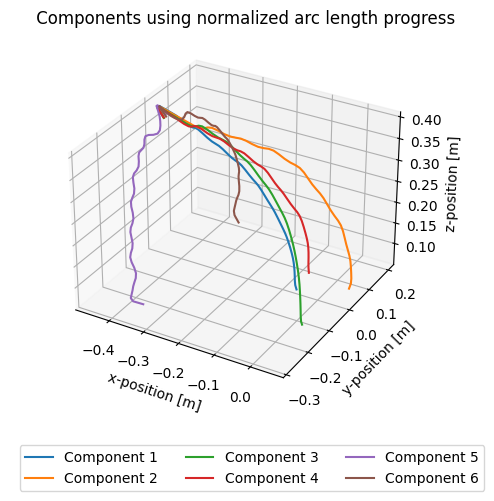

In [7]:
# Visualize the components in 3D
fig_time = plt.figure()
fig_arc = plt.figure()
ax_time = fig_time.add_subplot(projection='3d')
ax_arc = fig_arc.add_subplot(projection='3d')

for i in range(0,len(data)):

    component_time = np.dot(radial_basis_time,weights_time[i:i+1].T)[:,0]
    component_arc = np.dot(radial_basis_arc,weights_arc[i:i+1].T)[:,0]

    ax_time.plot3D(component_time[0:len(new_progress)], component_time[len(new_progress):2*len(new_progress)], component_time[2*len(new_progress):3*len(new_progress)], label = "Component " + str(i+1))
    ax_arc.plot3D(component_arc[0:len(new_progress)], component_arc[len(new_progress):2*len(new_progress)], component_arc[2*len(new_progress):3*len(new_progress)], label = "Component " + str(i+1))

ax_time.set_xlabel("x-position [m]")
ax_time.set_ylabel("y-position [m]")
ax_time.set_zlabel("z-position [m]")
ax_arc.set_xlabel("x-position [m]")
ax_arc.set_ylabel("y-position [m]")
ax_arc.set_zlabel("z-position [m]")
ax_time.legend(ncols = 3, bbox_to_anchor=(1.2, -0.1))
ax_arc.legend(ncols = 3, bbox_to_anchor=(1.2, -0.1))
ax_time.set_title("       Components using normalized time progress")
ax_arc.set_title("     Components using normalized arc length progress");

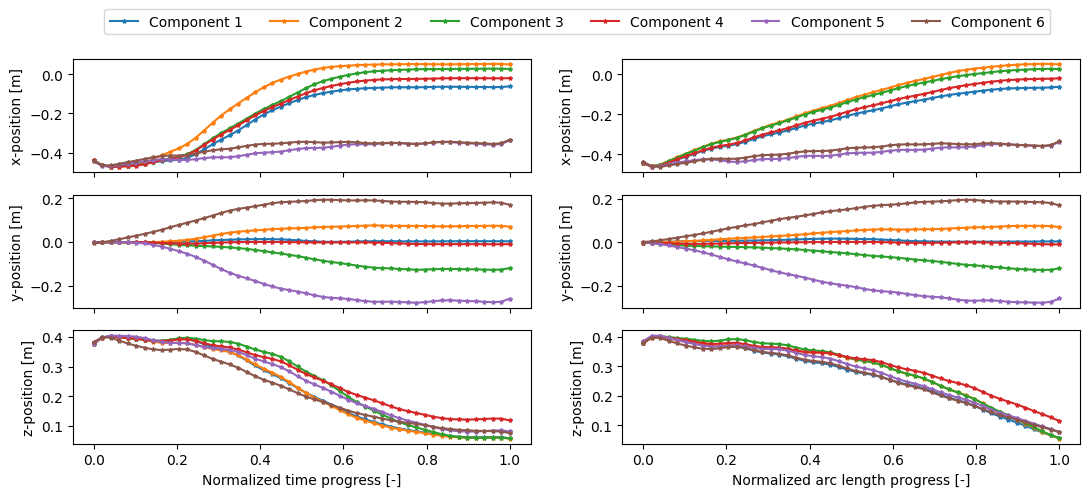

In [8]:
# Visualize the components in function of progress
fig, ax = plt.subplots(len(resampled_data_time[0]), 2, figsize = (13,5,))

for i in range(0,len(data)):

    component_time = np.dot(radial_basis_time,weights_time[i:i+1].T)[:,0]
    component_arc = np.dot(radial_basis_arc,weights_arc[i:i+1].T)[:,0]

    for j in range(0,len(ax)):
        
        if j < len(ax)-1:
            ax[j,0].plot(new_progress, component_time[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50))
            ax[j,1].plot(new_progress, component_arc[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50))
            ax[j,0].xaxis.set_tick_params(labelbottom=False)
            ax[j,1].xaxis.set_tick_params(labelbottom=False)
        else:
            ax[j,0].plot(new_progress, component_time[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50), label = "Component " + str(i+1))
            ax[j,1].plot(new_progress, component_arc[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50))
            ax[j,0].set_xlabel("Normalized time progress [-]")
            ax[j,1].set_xlabel("Normalized arc length progress [-]")

ax[0,0].set_ylabel("x-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[2,1].set_ylabel("z-position [m]") 
ax[2,0].legend(ncols = 6, bbox_to_anchor=(2.15, 3.9));  

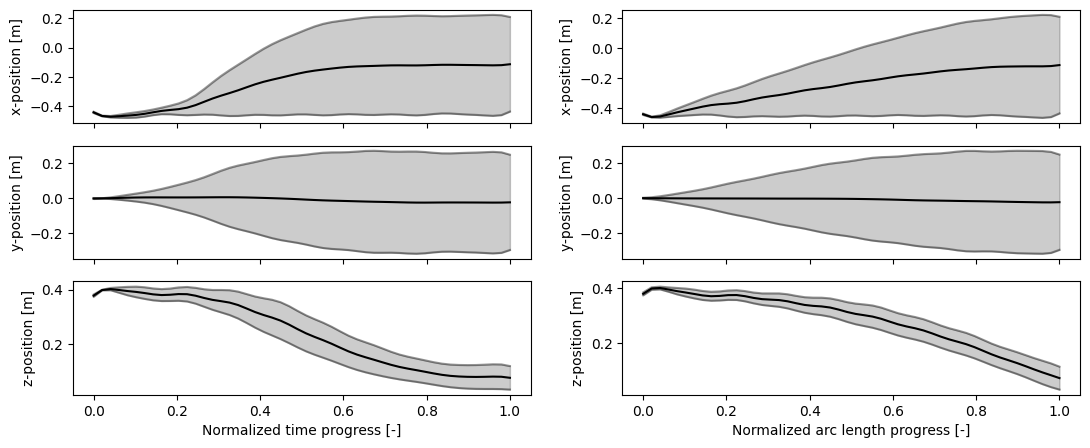

In [9]:
# Determine the mean of the ProMP models
ProMP_mean_time = np.dot(radial_basis_time,weight_mean_time.T)
ProMP_mean_arc = np.dot(radial_basis_arc,weight_mean_arc.T)

# Determine the covariance of the ProMP models
ProMP_cov_time = np.dot(np.dot(radial_basis_time, weight_cov_time), radial_basis_time.T)
ProMP_cov_arc = np.dot(np.dot(radial_basis_arc, weight_cov_arc), radial_basis_arc.T)

# Determine the standard deviation of the ProMP model
ProMP_std_time = np.array([np.sqrt(np.abs(ProMP_cov_time[i][i])) for i in range(0, len(ProMP_cov_time))])
ProMP_std_arc = np.array([np.sqrt(np.abs(ProMP_cov_arc[i][i])) for i in range(0, len(ProMP_cov_arc))])

# Visualize the ProMP model
fig, ax = plt.subplots(len(resampled_data_time[0]), 2, figsize = (13,5,))
for i in range(0, len(resampled_data_time[0])):

    # Plot the mean
    ax[i,0].plot(new_progress, ProMP_mean_time[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i,0].plot(new_progress, ProMP_mean_time[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_time[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].plot(new_progress, ProMP_mean_time[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_time[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].fill_between(new_progress, ProMP_mean_time[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_time[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_time[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_time[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i,0].xaxis.set_tick_params(labelbottom=False)

for i in range(0, len(resampled_data_arc[0])):

    # Plot the mean
    ax[i,1].plot(new_progress, ProMP_mean_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i,1].plot(new_progress, ProMP_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].plot(new_progress, ProMP_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].fill_between(new_progress, ProMP_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_arc[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i,1].xaxis.set_tick_params(labelbottom=False)
    
ax[0,0].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,1].set_ylabel("z-position [m]")
ax[2,0].set_xlabel("Normalized time progress [-]")
ax[2,1].set_xlabel("Normalized arc length progress [-]");

## 4. Trajectory parameterized Probabilistic Principal Component Analysis (TraPPCA)

Trajectory parameterized Probabilistic Principal Component Analysis (TraPPCA) is based on the dimensionality reduction technique PPCA, employing a linear latent variable model:<br><br>
$\bar{\bold{f}}^{\ T} = \bar{\bold{H}}\bold{\chi} + \bar{\bold{b}} + \bar{\bold{\epsilon}}$,<br><br>
with $\bar{\bold{f}}^{\ T} \in \mathbb{R}^{N_{resampled}N_{dim}}$ a single column vector representing an $N_{dim}$-dimensional trajectory. $\bar{\bold{H}} \in \mathbb{R}^{N_{resampled}N_{dim} \times m}$ is a matrix containing $m$ basis functions, which encode the variability and are weighted by the latent variable vector $\bold{\chi}$, distributed as: <br><br>
$\bold{\chi} \sim N(\bold{0},\bold{I}_m)$ <br><br>
$\bar{\bold{b}} \in \mathbb{R}^{N_{resampled}N_{dim}}$ represents the mean trajectory of the motion model and $\bar{\bold{\epsilon}} \in \mathbb{R}^{N_{resampled}N_{dim}}$ is a Gaussian noise vector:<br><br>
$\bar{\bold{\epsilon}} \sim N(\bold{0},\sigma^2\bold{I}_{N_{resampled}N_{dim}})$<br><br>
For a given number of latent variables $m$, the values for $\bar{\bold{H}}$, $\bar{\bold{b}}$ and $\bar{\bold{\epsilon}}$ are calculated from a set of $N_{demo}$ training demonstrations employing maximum likelihood:<br><br>
$\bar{\bold{b}} = \frac{1}{N_{demo}} \sum_{k=1}^{N_{demo}} \bold{y_k}$<br><br>
$\sigma^2 = \frac{1}{N_{dim}N_{resampled}-m} \sum_{k=m+1}^{N_{dim}N_{resampled}}\lambda_k$<br><br>
$\bar{\bold{H}} = \bold{U}_m(\bold{\Lambda}_m - \sigma^2\bold{I}_m)^{1/2}\bold{R}$<br><br>
where $\bold{y_k} \in \mathbb{R}^{N_{resampled}N_{dim}}$ is a single column vector representing training demonstration $k$ and $\bold{U}_m$ are the principal eigenvectors of the sample covariance matrix with corresponding eigenvalues $\lambda_1,...,\lambda_m$ in the diagonal matrix $\bold{\Lambda}_m$. $R$ corresponds to an arbitrary transformation matrix that, for convenience, is chosen as the identity.

In [10]:
from TraPPCA import TraPPCA

EXERCISE: Complete the function train in TraPPCA.py using the formulas explained above.

In [11]:
# Specify the desired number of modes
modes = 6

# Learn the TraPPCA model with normalized time progress
print("Normalized time progress:")
TraPPCA_model_time = TraPPCA(resampled_data_time, modes=modes)
TraPPCA_model_time.train()

# Learn the TraPPCA model with normalized arc length progress
print("\nNormalized arc length progress:")
TraPPCA_model_arc = TraPPCA(resampled_data_arc, modes=modes)
TraPPCA_model_arc.train()

Normalized time progress:
Retry training of TraPPCA model with less modes: modes = 6-> modes = 5

Normalized arc length progress:
Retry training of TraPPCA model with less modes: modes = 6-> modes = 5
Retry training of TraPPCA model with less modes: modes = 5-> modes = 4


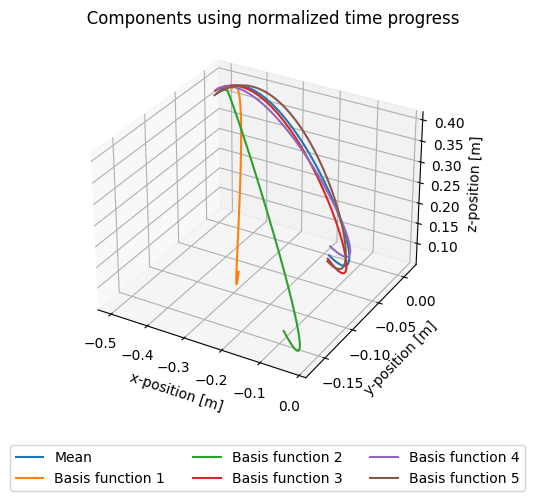

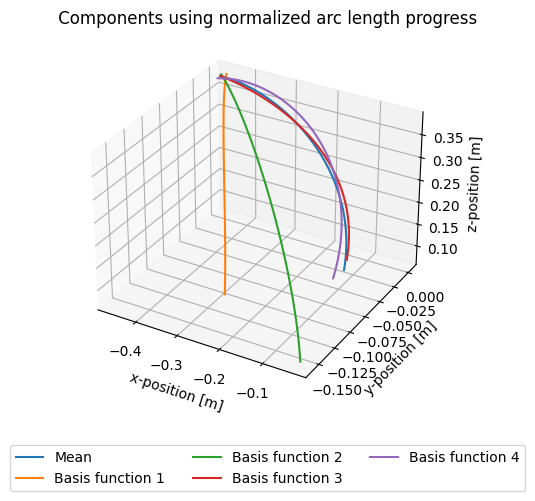

In [12]:
# Visualize the components in 3D
fig_time = plt.figure()
fig_arc = plt.figure()
ax_time = fig_time.add_subplot(projection='3d')
ax_arc = fig_arc.add_subplot(projection='3d')

# Evaluate the models at the given progress values
TraPPCA_basis_time, TraPPCA_mean_time = TraPPCA_model_time.evaluate_basisfunctions(new_progress)
TraPPCA_basis_arc, TraPPCA_mean_arc = TraPPCA_model_arc.evaluate_basisfunctions(new_progress)

# Plot the mean
ax_time.plot3D(TraPPCA_mean_time[0:len(new_progress)], TraPPCA_mean_time[len(new_progress):2*len(new_progress)], TraPPCA_mean_time[2*len(new_progress):3*len(new_progress)], label = "Mean")
ax_arc.plot3D(TraPPCA_mean_arc[0:len(new_progress)], TraPPCA_mean_arc[len(new_progress):2*len(new_progress)], TraPPCA_mean_arc[2*len(new_progress):3*len(new_progress)], label = "Mean")

# Plot the variability
for i in range(0, np.size(TraPPCA_basis_time,1)):
    ax_time.plot3D(TraPPCA_mean_time[0:len(new_progress)] + TraPPCA_basis_time[0:len(new_progress),i], 
                   TraPPCA_mean_time[len(new_progress):2*len(new_progress)] + TraPPCA_basis_time[len(new_progress):2*len(new_progress),i], 
                   TraPPCA_mean_time[2*len(new_progress):3*len(new_progress)] + TraPPCA_basis_time[2*len(new_progress):3*len(new_progress),i], label = "Basis function " + str(i+1))
for i in range(0, np.size(TraPPCA_basis_arc,1)):
    ax_arc.plot3D(TraPPCA_mean_arc[0:len(new_progress)] + TraPPCA_basis_arc[0:len(new_progress),i], 
                  TraPPCA_mean_arc[len(new_progress):2*len(new_progress)] + TraPPCA_basis_arc[len(new_progress):2*len(new_progress),i], 
                  TraPPCA_mean_arc[2*len(new_progress):3*len(new_progress)] + TraPPCA_basis_arc[2*len(new_progress):3*len(new_progress),i], label = "Basis function " + str(i+1))

ax_time.set_xlabel("x-position [m]")
ax_time.set_ylabel("y-position [m]")
ax_time.set_zlabel("z-position [m]")
ax_arc.set_xlabel("x-position [m]")
ax_arc.set_ylabel("y-position [m]")
ax_arc.set_zlabel("z-position [m]")
ax_time.legend(ncols = 3, bbox_to_anchor=(1.25, -0.1))
ax_arc.legend(ncols = 3, bbox_to_anchor=(1.25, -0.1))
ax_time.set_title("       Components using normalized time progress")
ax_arc.set_title("     Components using normalized arc length progress");

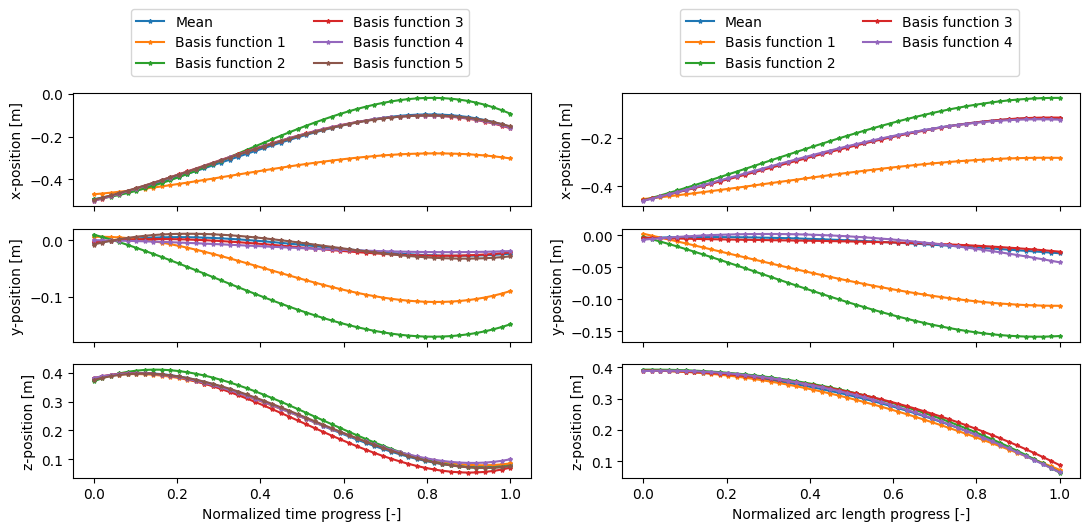

In [13]:
# Visualize the components in function of progress
fig, ax = plt.subplots(len(resampled_data_time[0]), 2, figsize = (13,5,))

for j in range(0,len(ax)):
    
    if j < len(ax)-1:
        
        # Plot the mean
        ax[j,0].plot(new_progress, TraPPCA_mean_time[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50))
        ax[j,1].plot(new_progress, TraPPCA_mean_arc[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50))

        # Plot the basis functions
        for i in range(0, np.size(TraPPCA_basis_time,1)):
            ax[j,0].plot(new_progress, TraPPCA_mean_time[j*len(new_progress):(j+1)*len(new_progress)] + TraPPCA_basis_time[j*len(new_progress):(j+1)*len(new_progress), i], "-*", markersize=3, markevery = int(len(new_progress)/50))
        for i in range(0, np.size(TraPPCA_basis_arc,1)):
            ax[j,1].plot(new_progress, TraPPCA_mean_arc[j*len(new_progress):(j+1)*len(new_progress)] + TraPPCA_basis_arc[j*len(new_progress):(j+1)*len(new_progress), i], "-*", markersize=3, markevery = int(len(new_progress)/50))

        ax[j,0].xaxis.set_tick_params(labelbottom=False)
        ax[j,1].xaxis.set_tick_params(labelbottom=False)
    else:

        # Plot the mean
        ax[j,0].plot(new_progress, TraPPCA_mean_time[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50), label = "Mean")
        ax[j,1].plot(new_progress, TraPPCA_mean_arc[j*len(new_progress):(j+1)*len(new_progress)], "-*", markersize=3, markevery = int(len(new_progress)/50), label = "Mean")

        # Plot the variability
        for i in range(0, np.size(TraPPCA_basis_time,1)):
            ax[j,0].plot(new_progress,  TraPPCA_mean_time[j*len(new_progress):(j+1)*len(new_progress)] + TraPPCA_basis_time[j*len(new_progress):(j+1)*len(new_progress), i], "-*", markersize=3, markevery = int(len(new_progress)/50), label = "Basis function " + str(i+1))
        for i in range(0, np.size(TraPPCA_basis_arc,1)):
            ax[j,1].plot(new_progress,  TraPPCA_mean_arc[j*len(new_progress):(j+1)*len(new_progress)] + TraPPCA_basis_arc[j*len(new_progress):(j+1)*len(new_progress), i], "-*", markersize=3, markevery = int(len(new_progress)/50), label = "Basis function " + str(i+1))
        ax[j,0].set_xlabel("Normalized time progress [-]")
        ax[j,1].set_xlabel("Normalized arc length progress [-]")

ax[0,0].set_ylabel("x-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[2,1].set_ylabel("z-position [m]") 
ax[2,0].legend(ncols = 2, bbox_to_anchor=(0.88, 4.2))  
ax[2,1].legend(ncols = 2, bbox_to_anchor=(0.88, 4.2))  

Text(0.5, 0, 'Normalized arc length progress [-]')

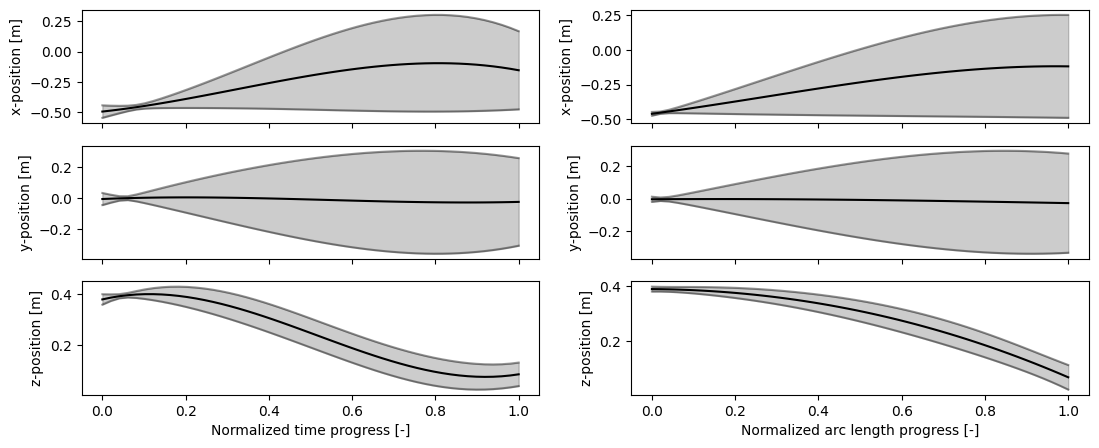

In [14]:
# Determine the covariance of the TraPPCA models
TraPPCA_cov_time = np.dot(TraPPCA_basis_time, TraPPCA_basis_time.T) + np.power(TraPPCA_model_time.meas_noise, 2) * np.eye(len(TraPPCA_mean_time))
TraPPCA_cov_arc = np.dot(TraPPCA_basis_arc, TraPPCA_basis_arc.T) + np.power(TraPPCA_model_arc.meas_noise, 2) * np.eye(len(TraPPCA_mean_arc))

# Determine the standard deviation of the TraPPCA models
TraPPCA_std_time = np.array([np.sqrt(np.abs(TraPPCA_cov_time[i][i])) for i in range(0, len(TraPPCA_cov_time))])
TraPPCA_std_arc = np.array([np.sqrt(np.abs(TraPPCA_cov_arc[i][i])) for i in range(0, len(TraPPCA_cov_arc))])

# Visualize the TraPPCA models
fig, ax = plt.subplots(len(resampled_data_time[0]), 2, figsize = (13,5,))
for i in range(0, len(resampled_data_time[0])):

    # Plot the mean
    ax[i,0].plot(new_progress, TraPPCA_mean_time[i*len(new_progress):(i+1)*len(new_progress)], color="black")
    ax[i,1].plot(new_progress, TraPPCA_mean_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i,0].plot(new_progress, TraPPCA_mean_time[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_time[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].plot(new_progress, TraPPCA_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].plot(new_progress, TraPPCA_mean_time[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_time[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].plot(new_progress, TraPPCA_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].fill_between(new_progress, TraPPCA_mean_time[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_time[i*len(new_progress):(i+1)*len(new_progress)], 
                       TraPPCA_mean_time[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_time[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    ax[i,1].fill_between(new_progress, TraPPCA_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_arc[i*len(new_progress):(i+1)*len(new_progress)], 
                       TraPPCA_mean_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i,0].xaxis.set_tick_params(labelbottom=False)
        ax[i,1].xaxis.set_tick_params(labelbottom=False)

ax[0,0].set_ylabel("x-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[2,1].set_ylabel("z-position [m]")
ax[2,0].set_xlabel("Normalized time progress [-]")
ax[2,1].set_xlabel("Normalized arc length progress [-]")

## 7. Trajectory generation

In this section, the learned ProMP and TraPPCA models are used to generate new trajectories based on a given end-point. To achieve this, the models are adapted to account for the known "via-point", which we refer to as conditioning the model on that via-point.

In [15]:
# Specify the new end-point
end_point = [0,0.1,0.1]

### 7.1 ProMP

For ProMP, conditioning on via-points is achieved using a Kalman filter approach. This Kalman filter approach is elaborated in function condition_on_viapoints of ProMP.py.

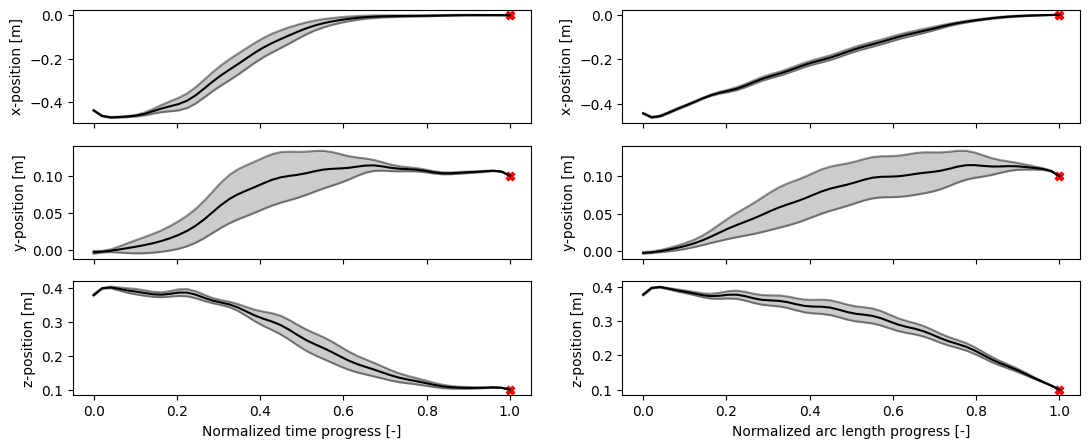

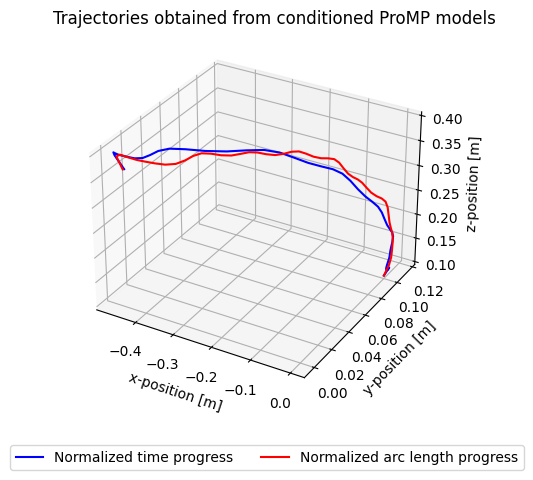

In [16]:
# Condition the ProMP model on the new end-point, where "value" contains the measurement, 
# "progress" contains the progress value and "sigma" contains the covariance matrix of the measurement.
viapoint = {
    "value": end_point,
    "progress": 1,
}

ProMP_model_time.append_via_points(viapoint)
ProMP_model_time.condition_on_viapoints();
ProMP_model_arc.append_via_points(viapoint)
ProMP_model_arc.condition_on_viapoints();

# Determine the mean of the ProMP model after conditioning
ProMP_mean_time_cond = np.dot(radial_basis_time,ProMP_model_time.weight_mean_cond.T)
ProMP_mean_arc_cond = np.dot(radial_basis_arc,ProMP_model_arc.weight_mean_cond.T)

# Determine the covariance of the ProMP model after conditioning
ProMP_cov_time_cond = np.dot(np.dot(radial_basis_time, ProMP_model_time.weight_cov_cond), radial_basis_time.T)
ProMP_cov_arc_cond = np.dot(np.dot(radial_basis_arc, ProMP_model_arc.weight_cov_cond), radial_basis_arc.T)

# Determine the standard deviation of the ProMP model after conditioning
ProMP_std_time_cond = np.array([np.sqrt(np.abs(ProMP_cov_time_cond[i][i])) for i in range(0, len(ProMP_cov_time_cond))])
ProMP_std_arc_cond = np.array([np.sqrt(np.abs(ProMP_cov_arc_cond[i][i])) for i in range(0, len(ProMP_cov_arc_cond))])

# Visualize the ProMP model in function of progress
fig, ax = plt.subplots(len(resampled_data_time[0]), 2, figsize = (13,5,))
for i in range(0, len(resampled_data_time[0])):

    # Plot the mean
    ax[i,0].plot(new_progress, ProMP_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i,0].plot(new_progress, ProMP_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].plot(new_progress, ProMP_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].fill_between(new_progress, ProMP_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i,0].xaxis.set_tick_params(labelbottom=False)

    # Plot the end-point
    ax[i,0].scatter(1,end_point[i], marker = "X", color = "red")

for i in range(0, len(resampled_data_arc[0])):

    # Plot the mean
    ax[i,1].plot(new_progress, ProMP_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i,1].plot(new_progress, ProMP_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].plot(new_progress, ProMP_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].fill_between(new_progress, ProMP_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i,1].xaxis.set_tick_params(labelbottom=False)

    # Plot the end-point
    ax[i,1].scatter(1,end_point[i], marker = "X", color = "red")
    
ax[0,0].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,1].set_ylabel("z-position [m]")
ax[2,0].set_xlabel("Normalized time progress [-]")
ax[2,1].set_xlabel("Normalized arc length progress [-]")

# Visualize the resulting trajectory in 3D
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.plot3D(ProMP_mean_time_cond[0:len(new_progress)], ProMP_mean_time_cond[len(new_progress):2*len(new_progress)], ProMP_mean_time_cond[2*len(new_progress):3*len(new_progress)], color = "blue", label = "Normalized time progress")
ax_3D.plot3D(ProMP_mean_arc_cond[0:len(new_progress)], ProMP_mean_arc_cond[len(new_progress):2*len(new_progress)], ProMP_mean_arc_cond[2*len(new_progress):3*len(new_progress)], color = "red", label = "Normalized arc length progress")
ax_3D.set_xlabel("x-position [m]")
ax_3D.set_ylabel("y-position [m]")
ax_3D.set_zlabel("z-position [m]")
ax_3D.legend(ncols = 3, bbox_to_anchor=(1.25, -0.1))
ax_3D.set_title("        Trajectories obtained from conditioned ProMP models")

# Undo the conditioning
ProMP_model_time.clear_cond()

### 7.2 TraPPCA

For TraPPCA, conditioning on via-points is achieved using a similar Kalman filter approach as for ProMP. 

EXERCISE: Complete function condition_on_viapoints in TraPPCA.py, analogous to condition_on_viapoints in ProMP.py

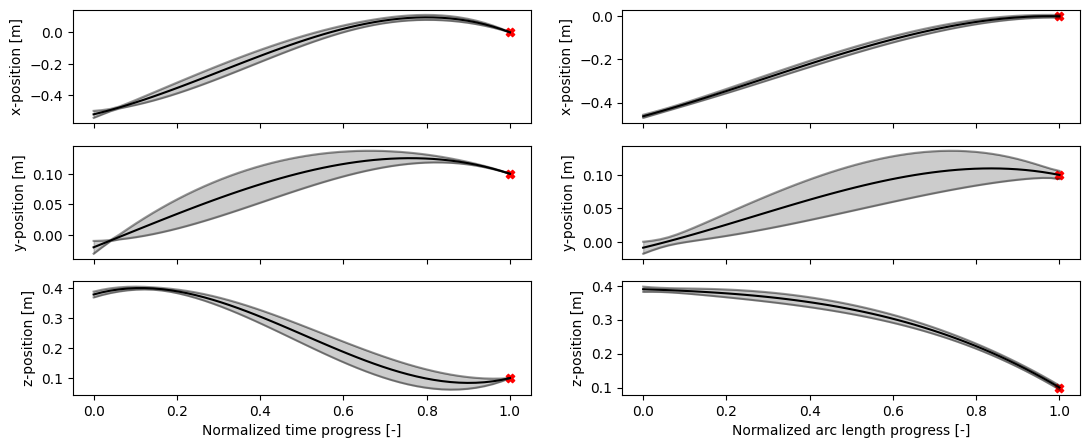

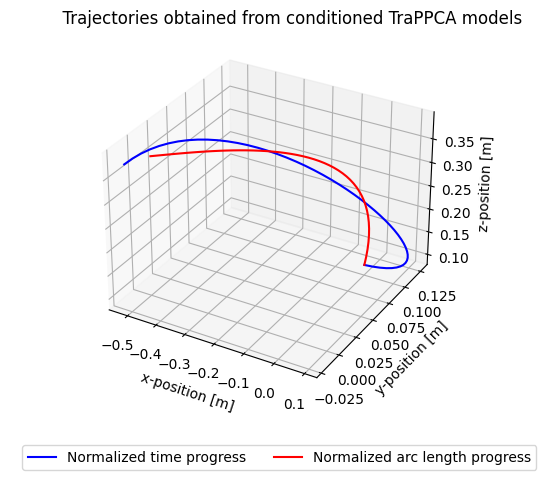

In [17]:
# Condition the TraPPCA model on the new end-point, where "value" contains the measurement, 
# "progress" contains the progress value and "sigma" contains the covariance matrix of the measurement.
viapoint = {
    "value": end_point,
    "progress": 1,
}

TraPPCA_model_time.append_via_points(viapoint)
TraPPCA_model_arc.append_via_points(viapoint)

TraPPCA_model_time.condition_on_viapoints();
TraPPCA_model_arc.condition_on_viapoints();

# Determine the mean of the TraPPCA models
TraPPCA_mean_time_cond = np.dot(TraPPCA_basis_time, TraPPCA_model_time.x_cond) + TraPPCA_mean_time
TraPPCA_mean_arc_cond = np.dot(TraPPCA_basis_arc, TraPPCA_model_arc.x_cond) + TraPPCA_mean_arc

# Determine the covariance of the TraPPCA models
TraPPCA_cov_time_cond = np.dot(np.dot(TraPPCA_basis_time, TraPPCA_model_time.sigma_cond), TraPPCA_basis_time.T) + np.power(TraPPCA_model_time.meas_noise, 2) * np.eye(len(TraPPCA_mean_time))
TraPPCA_cov_arc_cond = np.dot(np.dot(TraPPCA_basis_arc, TraPPCA_model_arc.sigma_cond), TraPPCA_basis_arc.T) + np.power(TraPPCA_model_arc.meas_noise, 2) * np.eye(len(TraPPCA_mean_arc))

# Determine the standard deviation of the TraPPCA models
TraPPCA_std_time_cond = np.array([np.sqrt(np.abs(TraPPCA_cov_time_cond[i][i])) for i in range(0, len(TraPPCA_cov_time_cond))])
TraPPCA_std_arc_cond = np.array([np.sqrt(np.abs(TraPPCA_cov_arc_cond[i][i])) for i in range(0, len(TraPPCA_cov_arc_cond))])

# Visualize the TraPPCA models in function of progress
fig, ax = plt.subplots(len(resampled_data_time[0]), 2, figsize = (13,5,))
for i in range(0, len(resampled_data_time[0])):

    # Plot the mean
    ax[i,0].plot(new_progress, TraPPCA_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black")
    ax[i,1].plot(new_progress, TraPPCA_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i,0].plot(new_progress, TraPPCA_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].plot(new_progress, TraPPCA_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].plot(new_progress, TraPPCA_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,1].plot(new_progress, TraPPCA_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i,0].fill_between(new_progress, TraPPCA_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], 
                       TraPPCA_mean_time_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_time_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    ax[i,1].fill_between(new_progress, TraPPCA_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] - 2*TraPPCA_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], 
                       TraPPCA_mean_arc_cond[i*len(new_progress):(i+1)*len(new_progress)] + 2*TraPPCA_std_arc_cond[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i,0].xaxis.set_tick_params(labelbottom=False)
        ax[i,1].xaxis.set_tick_params(labelbottom=False)

    # Plot the end-point
    ax[i,0].scatter(1,end_point[i], marker = "X", color = "red")
    ax[i,1].scatter(1,end_point[i], marker = "X", color = "red")

ax[0,0].set_ylabel("x-position [m]")
ax[0,1].set_ylabel("x-position [m]")
ax[1,0].set_ylabel("y-position [m]")
ax[1,1].set_ylabel("y-position [m]")
ax[2,0].set_ylabel("z-position [m]")
ax[2,1].set_ylabel("z-position [m]")
ax[2,0].set_xlabel("Normalized time progress [-]")
ax[2,1].set_xlabel("Normalized arc length progress [-]")

# Visualize the resulting trajectories in 3D
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.plot3D(TraPPCA_mean_time_cond[0:len(new_progress)], TraPPCA_mean_time_cond[len(new_progress):2*len(new_progress)], TraPPCA_mean_time_cond[2*len(new_progress):3*len(new_progress)], color = "blue", label = "Normalized time progress")
ax_3D.plot3D(TraPPCA_mean_arc_cond[0:len(new_progress)], TraPPCA_mean_arc_cond[len(new_progress):2*len(new_progress)], TraPPCA_mean_arc_cond[2*len(new_progress):3*len(new_progress)], color = "red", label = "Normalized arc length progress")
ax_3D.set_xlabel("x-position [m]")
ax_3D.set_ylabel("y-position [m]")
ax_3D.set_zlabel("z-position [m]")
ax_3D.legend(ncols = 3, bbox_to_anchor=(1.25, -0.1))
ax_3D.set_title("          Trajectories obtained from conditioned TraPPCA models")

# Undo the conditioning
TraPPCA_model_time.clear_cond()
TraPPCA_model_arc.clear_cond()

## 8. Exercise: blending

Question 1: Express the above training demonstrations with respect to their start position and use them to train a ProMP model with normalized arc length progress

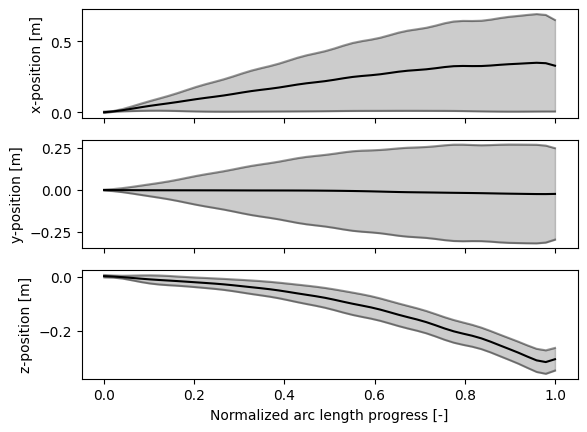

In [18]:
# Initialize the data structures
resampled_data_start_arc = np.empty([len(data), np.size(data[0], 1)-1, len(new_progress)])

# Express the training demonstrations with respect to their start position
for i in range(0, len(data)):
    for j in range(0, len(resampled_data_time[0])):
        resampled_data_start_arc[i][j] = resampled_data_arc[i][j] - resampled_data_arc[i][j][0]

# Learn the ProMP model with normalized arc length progress
ProMP_model_start_arc = ProMP(resampled_data_start_arc, 10)
radial_basis_start_arc, weights_start_arc, weight_mean_start_arc, weight_cov_start_arc = ProMP_model_start_arc.train(lmbda = 1e-12, width = 3.5*10**(-3), normalize = True)

# Determine the mean of the ProMP model
ProMP_mean_start_arc = np.dot(radial_basis_start_arc,weight_mean_start_arc.T)

# Determine the covariance of the ProMP model
ProMP_cov_start_arc = np.dot(np.dot(radial_basis_start_arc, weight_cov_start_arc), radial_basis_start_arc.T)

# Determine the standard deviation of the ProMP model
ProMP_std_start_arc = np.array([np.sqrt(np.abs(ProMP_cov_start_arc[i][i])) for i in range(0, len(ProMP_cov_start_arc))])

# Visualize the ProMP model
fig, ax = plt.subplots(len(resampled_data_start_arc[0]))
for i in range(0, len(resampled_data_start_arc[0])):

    # Plot the mean
    ax[i].plot(new_progress, ProMP_mean_start_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i].plot(new_progress, ProMP_mean_start_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i].plot(new_progress, ProMP_mean_start_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i].fill_between(new_progress, ProMP_mean_start_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_start_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i].xaxis.set_tick_params(labelbottom=False)

ax[0].set_ylabel("x-position [m]")
ax[1].set_ylabel("y-position [m]")
ax[2].set_ylabel("z-position [m]")
ax[2].set_xlabel("Normalized arc length progress [-]");

Question 2: Express the above training demonstrations with respect to their end position and use them to train a ProMP model with normalized arc length progress

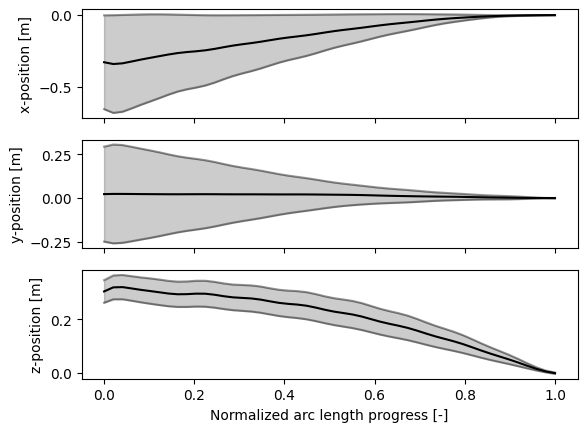

In [19]:
# Initialize the data structures
resampled_data_end_arc = np.empty([len(data), np.size(data[0], 1)-1, len(new_progress)])

# Express the training demonstrations with respect to their end position
for i in range(0, len(data)):
    for j in range(0, len(resampled_data_time[0])):
        resampled_data_end_arc[i][j] = resampled_data_arc[i][j] - resampled_data_arc[i][j][-1]

# Learn the ProMP model with normalized arc length progress
ProMP_model_end_arc = ProMP(resampled_data_end_arc, 10)
radial_basis_end_arc, weights_end_arc, weight_mean_end_arc, weight_cov_end_arc = ProMP_model_end_arc.train(lmbda = 1e-12, width = 3.5*10**(-3), normalize = True)

# Determine the mean of the ProMP model
ProMP_mean_end_arc = np.dot(radial_basis_end_arc,weight_mean_end_arc.T)

# Determine the covariance of the ProMP model
ProMP_cov_end_arc = np.dot(np.dot(radial_basis_end_arc, weight_cov_end_arc), radial_basis_end_arc.T)

# Determine the standard deviation of the ProMP model
ProMP_std_end_arc = np.array([np.sqrt(np.abs(ProMP_cov_end_arc[i][i])) for i in range(0, len(ProMP_cov_end_arc))])

# Visualize the ProMP model
fig, ax = plt.subplots(len(resampled_data_end_arc[0]))
for i in range(0, len(resampled_data_end_arc[0])):

    # Plot the mean
    ax[i].plot(new_progress, ProMP_mean_end_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i].plot(new_progress, ProMP_mean_end_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i].plot(new_progress, ProMP_mean_end_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i].fill_between(new_progress, ProMP_mean_end_arc[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_end_arc[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i].xaxis.set_tick_params(labelbottom=False)

ax[0].set_ylabel("x-position [m]")
ax[1].set_ylabel("y-position [m]")
ax[2].set_ylabel("z-position [m]")
ax[2].set_xlabel("Normalized arc length progress [-]");

Question 3: For a new motion, the start and end position are located as provided below. Shift the ProMP models of questions 1 and 2 to correspond to these start/end positions, i.e. the mean of the model of question 1 should start in the provided start position and the mean of the model of question 2 should end in the provided end position.

In [20]:
# Specify the new start and end position
start_new = np.array([-0.4, 0, 0.4])
end_new = np.array([-0.4, -0.2, 0.1])

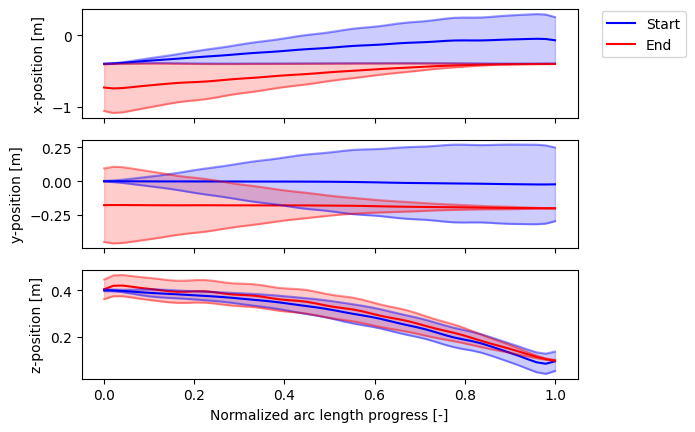

In [21]:
# Shift the mean of the ProMP models
ProMP_mean_start_new = np.empty(np.shape(ProMP_mean_start_arc))
ProMP_mean_end_new = np.empty(np.shape(ProMP_mean_end_arc))
for i in range(0,np.size(data[0], 1)-1):
    ProMP_mean_start_new[i*len(new_progress):(i+1)*len(new_progress)] = ProMP_mean_start_arc[i*len(new_progress):(i+1)*len(new_progress)] + start_new[i]
    ProMP_mean_end_new[i*len(new_progress):(i+1)*len(new_progress)] = ProMP_mean_end_arc[i*len(new_progress):(i+1)*len(new_progress)] + end_new[i]

# Visualize the shifted ProMP models
fig, ax = plt.subplots(len(resampled_data_end_arc[0]))
for i in range(0, len(resampled_data_end_arc[0])):

    # Plot the mean
    if i == 0:
        ax[i].plot(new_progress, ProMP_mean_start_new[i*len(new_progress):(i+1)*len(new_progress)], color="blue", label = "Start")
        ax[i].plot(new_progress, ProMP_mean_end_new[i*len(new_progress):(i+1)*len(new_progress)], color="red", label = "End")
    else:
        ax[i].plot(new_progress, ProMP_mean_start_new[i*len(new_progress):(i+1)*len(new_progress)], color="blue")
        ax[i].plot(new_progress, ProMP_mean_end_new[i*len(new_progress):(i+1)*len(new_progress)], color="red")

    # Plot the variability
    ax[i].plot(new_progress, ProMP_mean_start_new[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], color="blue", alpha=0.4)
    ax[i].plot(new_progress, ProMP_mean_start_new[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], color="blue", alpha=0.4)
    ax[i].fill_between(new_progress, ProMP_mean_start_new[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_start_new[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_start_arc[i*len(new_progress):(i+1)*len(new_progress)], color="blue", alpha=0.2)
    ax[i].plot(new_progress, ProMP_mean_end_new[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], color="red", alpha=0.4)
    ax[i].plot(new_progress, ProMP_mean_end_new[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], color="red", alpha=0.4)
    ax[i].fill_between(new_progress, ProMP_mean_end_new[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_end_new[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_end_arc[i*len(new_progress):(i+1)*len(new_progress)], color="red", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i].xaxis.set_tick_params(labelbottom=False)

ax[0].set_ylabel("x-position [m]")
ax[1].set_ylabel("y-position [m]")
ax[2].set_ylabel("z-position [m]")
ax[2].set_xlabel("Normalized arc length progress [-]");
fig.legend(bbox_to_anchor=(1.08, 0.89))

Question 4: Determine a representation for the new motion by blending the shifted ProMP models of question 3.

When performing blending with $M$ models, the mean $\bold{\mu}^{(blend)}(s)$ and the covariance $\bold{\Sigma}^{(blend)}(s)$ at progress value $s$ are calculated as <br>
$(\bold{\Sigma}^{(blend)}(s))^{-1} = \sum_{i=1}^{M} \alpha^{(i)}(s) \ (\bold{\Sigma}^{(i)}(s))^{-1}$ <br>
$\bold{\mu}^{(blend)}(s) = \bold{\Sigma}^{(blend)}(s) \ (\sum_{i=1}^M \alpha^{(i)}(s) \ (\bold{\Sigma}^{(i)}(s))^{-1} \bold{\mu}^{(i)}(s))$ <br>
with $\alpha^{(i)}(s)$ the blending factor of model $i$ at progress value $s$, $\bold{\Sigma}^{(i)}(s)$ the covariance of model $i$ at progress value $s$ and $\bold{\mu}^{(i)}(s)$ the mean of model $i$ at progress value $s$.

For this question, use the blending factors provided below.

In [22]:
alpha_start = np.linspace(1,0,len(new_progress))
alpha_end = np.linspace(0,1,len(new_progress))

In [23]:
# Initialize the data structures
ProMP_mean_blend = np.empty(np.shape(ProMP_mean_start_arc))
ProMP_cov_blend = np.empty(np.shape(ProMP_cov_start_arc))

# Iterate over the samples
for i in range(0,len(new_progress)):

    # Determine the means and covariances for the current sample
    ProMP_mean_start_i = ProMP_mean_start_new[i::len(new_progress)]
    ProMP_mean_end_i = ProMP_mean_end_new[i::len(new_progress)]
    ProMP_cov_start_i = ProMP_cov_start_arc[i::len(new_progress),i::len(new_progress)]
    ProMP_cov_end_i = ProMP_cov_end_arc[i::len(new_progress),i::len(new_progress)]

    # Calculate the mean and covariance after blending for the current sample
    ProMP_cov_blend[i::len(new_progress),i::len(new_progress)] = np.linalg.inv(np.linalg.inv(ProMP_cov_start_i)*alpha_start[i] + np.linalg.inv(ProMP_cov_end_i)*alpha_end[i])
    ProMP_mean_blend[i::len(new_progress)] = np.dot(ProMP_cov_blend[i::len(new_progress),i::len(new_progress)],
                                                    np.dot(np.linalg.inv(ProMP_cov_start_i)*alpha_start[i], ProMP_mean_start_i) + 
                                                    np.dot(np.linalg.inv(ProMP_cov_end_i)*alpha_end[i], ProMP_mean_end_i)
                                                    )

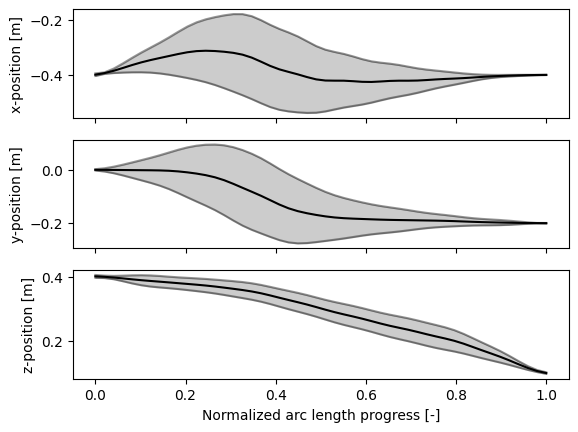

In [24]:
# Determine the standard deviation of the blended ProMP model
ProMP_std_blend = np.array([np.sqrt(np.abs(ProMP_cov_blend[i][i])) for i in range(0, len(ProMP_cov_blend))])

# Visualize the blended ProMP model
fig, ax = plt.subplots(len(resampled_data_end_arc[0]))
for i in range(0, len(resampled_data_end_arc[0])):

    # Plot the mean
    ax[i].plot(new_progress, ProMP_mean_blend[i*len(new_progress):(i+1)*len(new_progress)], color="black")

    # Plot the variability
    ax[i].plot(new_progress, ProMP_mean_blend[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_blend[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i].plot(new_progress, ProMP_mean_blend[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_blend[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.4)
    ax[i].fill_between(new_progress, ProMP_mean_blend[i*len(new_progress):(i+1)*len(new_progress)] - 2*ProMP_std_blend[i*len(new_progress):(i+1)*len(new_progress)], 
                       ProMP_mean_blend[i*len(new_progress):(i+1)*len(new_progress)] + 2*ProMP_std_blend[i*len(new_progress):(i+1)*len(new_progress)], color="black", alpha=0.2)
    
    if i < len(ax)-1:
        ax[i].xaxis.set_tick_params(labelbottom=False)

ax[0].set_ylabel("x-position [m]")
ax[1].set_ylabel("y-position [m]")
ax[2].set_ylabel("z-position [m]")
ax[2].set_xlabel("Normalized arc length progress [-]");